In [186]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table
from scipy.interpolate import interp1d

# Data

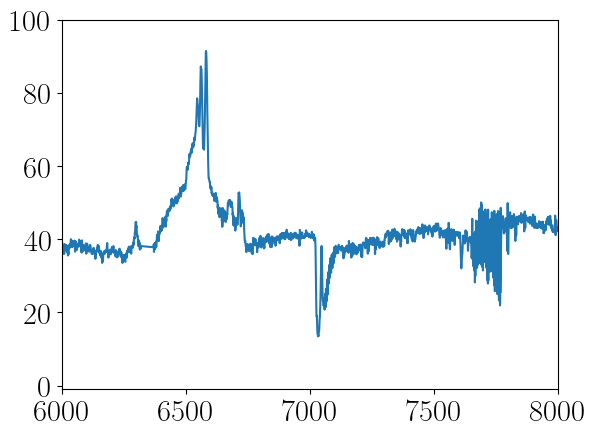

In [166]:
file_path = 'HET/combined_spectrum_20230113_0000022_exp01.fits'

t = Table.read(file_path)
t.sort('Wavelength')

z = 0.081
wl = t['Wavelength']/(1+z)
flux = t['F_lambda'] * (10**17)
err = t['e_F_lambda']

flux_lim = np.where(flux>0)[0]
wl=wl[flux_lim]
flux=flux[flux_lim]
err=err[flux_lim]

#wl_lim = np.where((wl>5900)&(wl<6950))
#wl=wl[wl_lim]
#flux=flux[wl_lim]
#err=err[wl_lim]

mask1 = np.where((wl<6320)|(wl>6370))
wl=wl[mask1]
flux=flux[mask1]
err=err[mask1]

plt.plot(wl, flux)
plt.xlim(6000, 8000)
plt.ylim(-1, 100)
plt.show()

# Correction

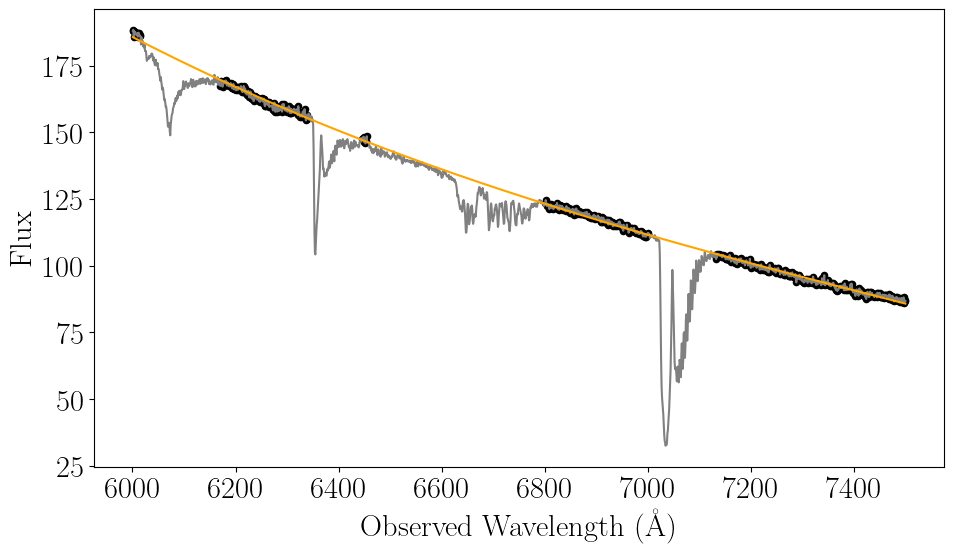

In [185]:
file_name = 'bundle_20230529_standards/spectrum_20230112_0000010_exp01_red.fits'
hdul = fits.open(file_name)
data = hdul[0].data
hdr = hdul[0].header

z = 0.081

wl = data[0]
flux = data[1] * (10**16)
err = data[2]


wl = wl / (1 + z)


mask0 = np.where((wl > 6000) & (wl < 7500))
wl_o = wl[mask0]
flux_o = flux[mask0]
err_o = err[mask0]


mask1 = np.where((wl_o < 6015) | (wl_o > 6170))
wl = wl_o[mask1]
flux = flux_o[mask1]
err = err_o[mask1]

mask2 = np.where((wl < 6340) | (wl > 6445))
wl = wl[mask2]
flux = flux[mask2]
err = err[mask2]

mask3 = np.where((wl < 6455) | (wl > 6800))
wl = wl[mask3]
flux = flux[mask3]
err = err[mask3]

mask4 = np.where((wl < 7000) | (wl > 7130))
wl = wl[mask4]
flux = flux[mask4]
err = err[mask4]


plt.figure(figsize=(10, 6))
plt.plot(wl_o, flux_o, color='grey')
plt.scatter(wl, flux, color='black', s=20)


coefficients = np.polyfit(wl, flux, 3)
polynomial = np.poly1d(coefficients)
fitted_continuum = polynomial(wl_o)

plt.plot(wl_o, fitted_continuum, color='orange')

plt.xlabel('Observed Wavelength (\AA)')
plt.ylabel('Flux')
plt.tight_layout()
plt.savefig("standard_spectra.pdf", format='pdf')
plt.show()



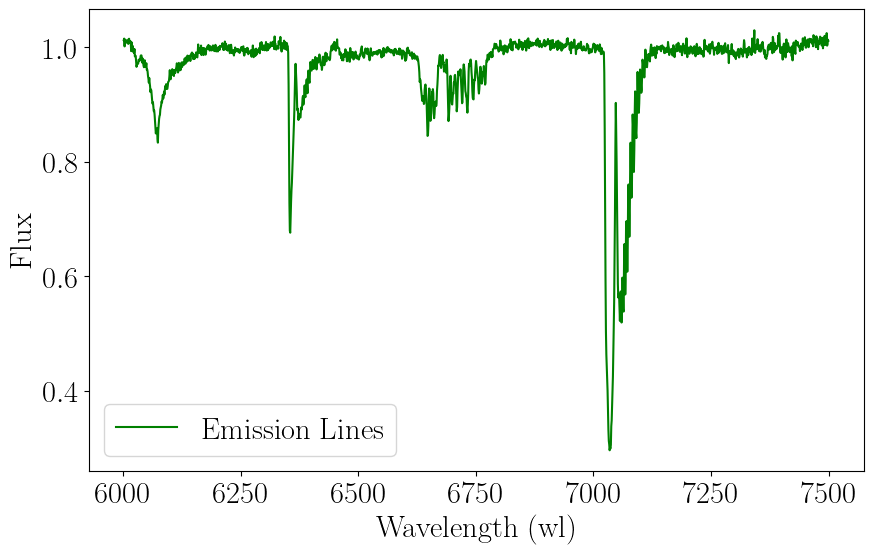

In [161]:
degree = 3

coefficients = np.polyfit(wl, flux, degree)
polynomial_continuum = np.poly1d(coefficients)(wl_o)
standard_flux = flux_o / polynomial_continuum
standard_wl = wl_o


plt.figure(figsize=(10, 6))
#plt.plot(wl_o, flux_o, label='Original Flux Data')
#plt.plot(wl_o, polynomial_continuum, label='Polynomial Continuum', color='orange')
plt.plot(standard_wl, standard_flux, label='Emission Lines', color='green')
plt.xlabel('Wavelength (wl)')
plt.ylabel('Flux')
#plt.ylim(0, 4)
plt.legend()
plt.show()

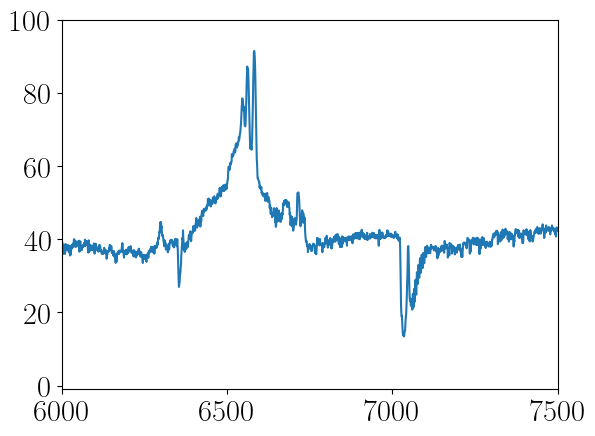

1715


In [162]:
file_path = 'HET/combined_spectrum_20230113_0000022_exp01.fits'

t = Table.read(file_path)
t.sort('Wavelength')

z = 0.081
wl = t['Wavelength']/(1+z)
flux = t['F_lambda'] * (10**17)
err = t['e_F_lambda'] * (10**17)

flux_lim = np.where(flux>0)[0]
source_wl=wl[flux_lim]
source_flux=flux[flux_lim]
source_err=err[flux_lim]

wl_lim = np.where((source_wl>6000)&(source_wl<7500))
source_wl=source_wl[wl_lim]
source_flux=source_flux[wl_lim]
source_err=source_err[wl_lim]


plt.plot(source_wl, source_flux)
plt.xlim(6000, 7500)
plt.ylim(-1, 100)
plt.show()

print(len(source_flux))

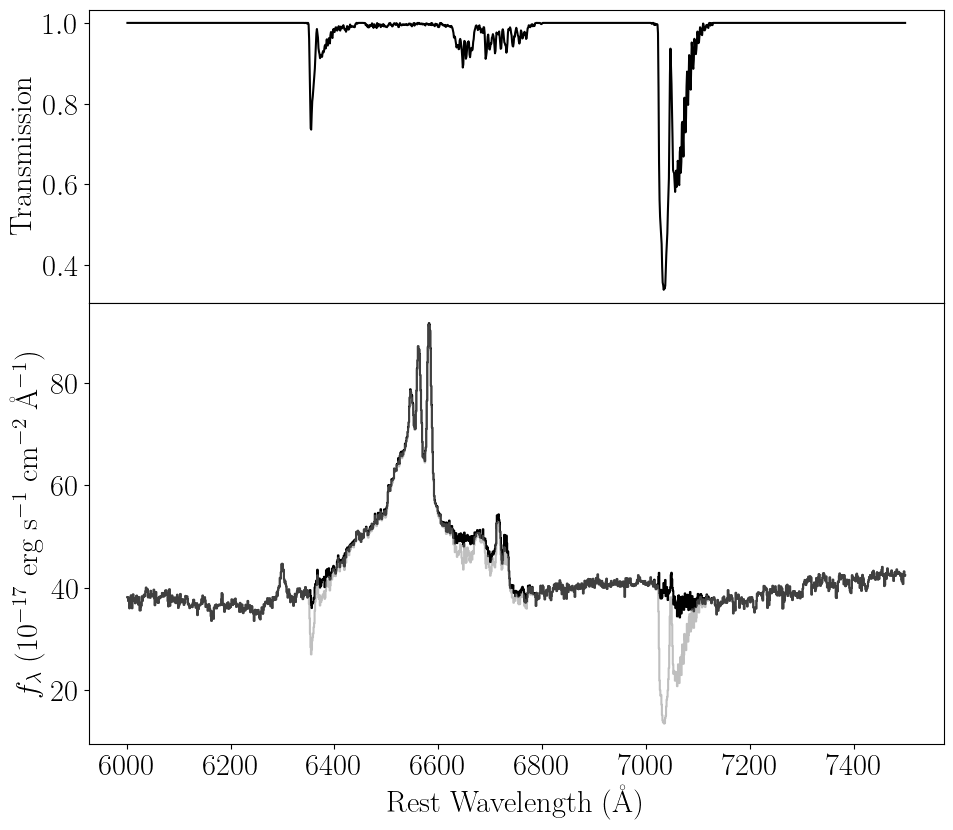

In [163]:
shift = 0
scale = 1.18

tmp = standard_flux

standard_wl = standard_wl + shift
tmp = (1-(1-tmp)**scale)
inf = np.where(np.isfinite(tmp) == False)[0]

standard_flux[inf] = 1
standard_flux = (1-(1-standard_flux)**scale)

mask1 = np.where(standard_wl < 6340)[0]
mask2 = np.where((standard_wl > 6445) & (standard_wl < 6455))[0]
mask3 = np.where((standard_wl > 6800) & (standard_wl < 7010))[0]
mask4 = np.where(standard_wl > 7130)[0]

standard_flux[mask1] = 1
standard_flux[mask2] = 1
standard_flux[mask3] = 1
standard_flux[mask4] = 1



bin_size = 1
bins = np.arange(start=min(np.min(source_wl), np.min(standard_wl)), stop=max(np.max(source_wl), np.max(standard_wl)) + bin_size, step=bin_size)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
wavelength = bin_centers


indices1 = np.digitize(source_wl, bins) - 1
indices2 = np.digitize(standard_wl, bins) - 1
source_flux = np.array([np.mean(source_flux[indices1 == i]) for i in range(len(bin_centers))])
standard_flux = np.array([np.mean(standard_flux[indices2 == i]) for i in range(len(bin_centers))])
binned_err = np.array([np.mean(source_err[indices1 == i]) for i in range(len(bin_centers))])



plt.rc('text', usetex=True)
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 22
})

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 1, height_ratios=[2, 3, 0], hspace=0)

ax1 = fig.add_subplot(gs[0]) 
ax2 = fig.add_subplot(gs[1])  
# Plotting on the first axis
ax1.plot(wavelength, standard_flux, color='black')
ax1.set_ylabel('Transmission')
ax1.tick_params(labelbottom=False) 

# Plotting on the second axis
ax2.plot(wavelength, source_flux / standard_flux, color='black', label='Corrected Spectrum', drawstyle='steps-mid')
ax2.plot(wavelength, source_flux, color='grey', label='Observed Spectrum', drawstyle='steps-mid', alpha=0.5)
ax2.set_xlabel('Rest Wavelength (\AA)')
ax2.set_ylabel("$f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)")

plt.tight_layout()
plt.savefig("spectrum_correction.pdf", format='pdf', dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


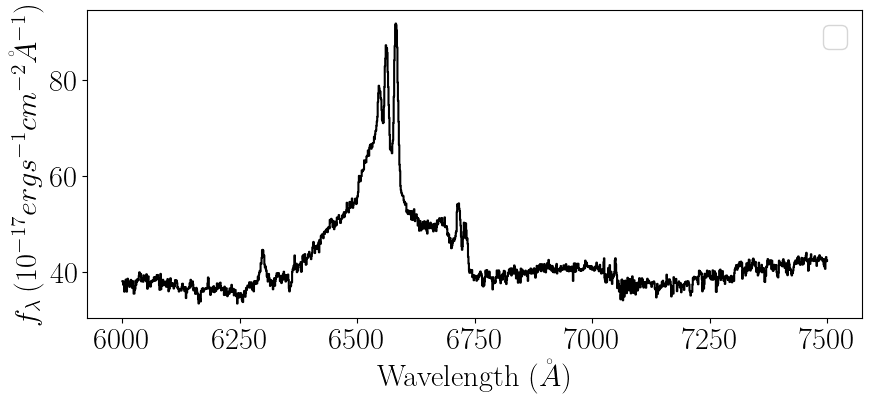

In [164]:
corrected_flux = source_flux / standard_flux
corrected_wl = bin_centers


plt.figure(figsize=(10, 4))
plt.plot(wavelength, corrected_flux, color="black", drawstyle='steps-mid')
#plt.axvline(x=6564.93, color='r', linestyle='--', linewidth=1, label="Halpha")
#plt.axvline(x=6085.90, color='orange', linestyle='--', linewidth=1, label="FVII")
#plt.axvline(x=6551.06, color='g', linestyle='--', linewidth=1, label="NII")
#plt.axvline(x=6585.64, color='g', linestyle='--', linewidth=1, label="NII")
#plt.axvline(x=6370, color='b', linestyle='--', linewidth=1, label="OI")
#plt.axvline(x=6303, color='b', linestyle='--', linewidth=1, label="OI")
#plt.axvline(x=6719, color='y', linestyle='--', linewidth=1, label="SII")
#plt.axvline(x=6734, color='y', linestyle='--', linewidth=1, label="SII")
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel("$f_{\lambda} \: (10^{-17} erg s^{-1} cm^{-2} \AA^{-1})$")
plt.legend()
plt.show()



## Functions

In [119]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [120]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [121]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(fwhm),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [122]:
def optical_agn_spectrum(wave_to_fit,pl_s,pl_e,\
                         sii1_f,sii1_cent,sii1_fwhm,\
                         sii2_f,sii2_cent,sii2_fwhm,\
                         oi1_f,oi1_cent,oi1_fwhm,\
                         oi2_f,oi2_cent,oi2_fwhm,\
                         fevii_f,fevii_cent,fevii_fwhm,\
                         nii1_f,nii1_cent,nii1_fwhm,\
                         nii2_f,nii2_cent,nii2_fwhm,\
                         halpha1_f,halpha1_cent,halpha1_fwhm,\
                         halpha2_f,halpha2_cent,halpha2_fwhm,\
                         halpha3_f,halpha3_cent,halpha3_fwhm,\
                         halpha4_f,halpha4_cent,halpha4_fwhm,\
                         return_components=False,return_hyperfine_components=False):
    """
    Calculates a full optical AGN spectral model.
    """
    
    #x = wave_to_fit.to_value()
    x = np.array(wave_to_fit)
    y = np.zeros_like(x)
    
    # powerlaw
    pl = powerlaw(x,pl_s,pl_e)      

    # broad [S II] - 6718.85 & 6733.72
    sii1 = gaussian(x,sii1_f,sii1_cent,sii1_fwhm,normalized=False)
    sii2 = gaussian(x,sii2_f,sii2_cent,sii2_fwhm,normalized=False)
    
    oi1 = gaussian(x,oi1_f,oi1_cent,oi1_fwhm,normalized=False)
    oi2 = gaussian(x,oi2_f,oi2_cent,oi2_fwhm,normalized=False)
    
    fevii = gaussian(x,fevii_f,fevii_cent,fevii_fwhm,normalized=False)
    
    nii1 = gaussian(x,nii1_f,nii1_cent,nii1_fwhm,normalized=False)
    nii2 = gaussian(x,nii2_f,nii2_cent,nii2_fwhm,normalized=False)
    
    # narrow and broad halpha line
    halpha1 = gaussian(x,halpha1_f,halpha1_cent,halpha1_fwhm,normalized=False)
    halpha2 = gaussian(x,halpha2_f,halpha2_cent,halpha2_fwhm,normalized=False)
    halpha3 = gaussian(x,halpha3_f,halpha3_cent,halpha3_fwhm,normalized=False)
    halpha4 = gaussian(x,halpha4_f,halpha4_cent,halpha4_fwhm,normalized=False)

    y = pl + sii1 + sii2 + halpha1 + halpha2 + halpha3 + halpha4 + nii1 + nii2 + oi1 + oi2 + fevii
    
    if return_components:
        y = {'model':y,\
             'pl':pl,\
            'sii1':sii1,\
             'sii2':sii2,\
             'oi1':oi1,\
             'oi2':oi2,\
             'fevii':fevii,\
             'nii1':nii1,\
            'nii2':nii2,\
            'halpha1':halpha1,\
            'halpha2':halpha2,\
            'halpha3':halpha3,\
            'halpha4':halpha4} 
    
    return y

In [123]:
def pl_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(plaw, 2,
            parnames=['scale','power'], 
            parlimited=[(False,False),(False,False)], 
            parlimits=[(0,0),(0,0)], 
            shortvarnames=('S','P')
            )
    myclass.__name__ = "pl"
    
    return myclass

In [124]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [125]:
def optical_agn_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(optical_agn_spectrum, 35,
            parnames=['pl_s','pl_e',\
                     'sii1_f','sii1_cent','sii1_fwhm',\
                      'sii2_f','sii2_cent','sii2_fwhm',\
                      'oi1_f','oi1_cent','oi1_fwhm',\
                      'oi2_f','oi2_cent','oi2_fwhm',\
                      'fevii_f','fevii_cent','fevii_fwhm',\
                      'nii1_f','nii1_cent','nii1_fwhm',\
                     'nii2_f','nii2_cent','nii2_fwhm',\
                     'halpha1_f','halpha1_cent','halpha1_fwhm',\
                     'haplha2_f','halpha2_cent','halpha2_fwhm',\
                     'haplha3_f','halpha3_cent','halpha3_fwhm',\
                     'haplha4_f','halpha4_cent','halpha4_fwhm'], 
            parlimited=[(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),], 
            parlimits=[(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0)]
            )
    myclass.__name__ = "optagn"
    
    return myclass

In [196]:
def plot_optical_agn_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    
    sii1 = model['sii1']
    sii2 = model['sii2']
    oi1 = model['oi1']
    oi2 = model['oi2']
    fevii = model['fevii']
    halpha1 = model['halpha1']
    halpha2 = model['halpha2']
    halpha3 = model['halpha3']
    halpha4 = model['halpha4']
    nii1 = model['nii1'] 
    nii2 = model['nii2']
    
    plt.rc('text', usetex=True)
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 22
    })
    fig = plt.figure(figsize=(18, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=pink,lw=2)
    ax.plot(wave,model['pl'],color=royal_blue)
    ax.plot(wave,sii1,color=salmon)
    ax.plot(wave,sii2,color=salmon)
    ax.plot(wave,oi1,color=salmon)
    ax.plot(wave,oi2,color=salmon)
    ax.plot(wave,fevii,color=turquoise)
    ax.plot(wave,halpha1,color=salmon)
    ax.plot(wave,halpha2,color=turquoise)
    ax.plot(wave,halpha3,color=turquoise)
    ax.plot(wave,halpha4,color=turquoise)
    ax.plot(wave,nii1,color=salmon)
    ax.plot(wave,nii2,color=salmon)
    ax.set_xlim(wavemin,wavemax)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins='auto'))
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()
    if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)
    
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(4700,5100)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_Hbfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    #
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(3715,4450)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_SBfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    

## Setup for plotting

In [197]:
# SETUP 
##############################################################
##############################################################
fontfamily = 'Times New Roman'
matplotlib.rcParams['font.family'] = fontfamily
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font',size=24,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'

blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

## Fit parameters from a rough spectral decomposition

Do a very rough spectral decomposition to the H$\beta$ region in order to get some guesses for starting parameters in this regime.

This creates a "continuum subtracted" spectrum by subtracting a hardcoded value, then fits Gaussians and saves their best-fit values to use as a starting guess later. It won't work on any other spectrum because of the continuum subtraction.

In [198]:
flux = corrected_flux
lam = corrected_wl
err = binned_err


In [199]:
sii1 = 6718.85
sii2 = 6733.72
halpha = 6564.93
nii1 = 6551.06
nii2 = 6585.64
oi2 = 6370.46
oi1 = 6303.05
fevii = 6085.90

sii2_off = sii2/sii1
nii1_off = nii1/sii1
nii2_off = nii2/sii1
oi1_off = oi1/sii1
oi2_off = oi2/sii1
halpha_off = halpha/sii1
fevii_off = fevii/sii1 


c = 2.99e5 # km/s

In [200]:
guesses = [5,0,\
          10, sii1, 800,\
           10, sii2, 800,\
           10, oi1, 800,\
           10, oi2, 800,\
           10, fevii, 800,\
          10, nii1, 800,\
           10, nii2, 800,\
          10, halpha, 800,\
          5, halpha, 3000,\
          5, halpha, 1500,\
          5, 6700, 1500]
           
tied = ['','',\
       '', '', '',\
        '', 'p[3] * {0}'.format(sii2_off), 'p[4]',\
        '', 'p[3] * {0}'.format(oi1_off), 'p[4]',\
        'p[8]/3', 'p[3] * {0}'.format(oi2_off), 'p[4]',\
        '', 'p[3] * {0}'.format(fevii_off), '',\
       '', 'p[3] * {0}'.format(nii1_off), 'p[4]',\
        '', 'p[3] * {0}'.format(nii2_off), 'p[4]',\
       '', 'p[3] * {0}'.format(halpha_off), 'p[4]',\
       '', '', '',\
       'p[26]/3', '', '',\
       '', '', '']

step = [0.5, 0.05,\
       0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
       0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
       0.5, 0.1, 5,\
        0.5, 0.1, 5,\
       0.5, 0.1, 5]

fixed = [0,0,\
        0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
        0,0,0,\
         0,0,0,\
        0,0,0,\
         0,0,0,\
         0,0,0,\
        0,0,0]

In [201]:
print(len(guesses))

35


In [202]:
# this actually does the fit after resetting the spectrum
spec = pyspeckit.Spectrum(data=flux,xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('opticalagn',optical_agn_fitter(),35)
spec.specfit.selectregion(xmin=6000,xmax=7000)
spec.specfit(fittype='opticalagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,parsteps=step,maxiter=500,baseline=False,subtract_baseline=False,quiet=False)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1000 [pyspeckit.spectrum.interactive]
Iter       1    CHI-SQUARE =  3950370.585  DOF =  980
   PL_S0 = 5  
   PL_E0 = 0  
   SII1_F0 = 10  
   SII1_CENT0 = 6718.85  
   SII1_FWHM0 = 800  
   SII2_F0 = 10  
   SII2_CENT0 = 6733.72  
   SII2_FWHM0 = 800  
   OI1_F0 = 10  
   OI1_CENT0 = 6303.05  
   OI1_FWHM0 = 800  
   OI2_F0 = 3.333333333  
   OI2_CENT0 = 6370.46  
   OI2_FWHM0 = 800  
   FEVII_F0 = 10  
   FEVII_CENT0 = 6085.9  
   FEVII_FWHM0 = 800  
   NII1_F0 = 10  
   NII1_CENT0 = 6551.06  
   NII1_FWHM0 = 800  
   NII2_F0 = 10  
   NII2_CENT0 = 6585.64  
   NII2_FWHM0 = 800  
   HALPHA1_F0 = 10  
   HALPHA1_CENT0 = 6564.93  
   HALPHA1_FWHM0 = 800  
   HAPLHA2_F0 = 5  
   HALPHA2_CENT0 = 6564.93  
   HALPHA2_FWHM0 = 3000  
   HAPLHA3_F0 = 1.666666667  
   HALPHA3_CENT0 = 6564.93  
   HALPHA3_FWHM0 = 1500  
   HAPLHA4_F0 = 5  
   HALPHA4_CENT0 = 6700  
   HALPHA4_FWHM0 = 1500  
Iter       2    CHI-SQUARE =  844912.116  DO

Iter       9    CHI-SQUARE =  191276.6017  DOF =  980
   PL_S0 = -16.74722085  
   PL_E0 = 0.3860008374  
   SII1_F0 = 10.48947955  
   SII1_CENT0 = 7138.665957  
   SII1_FWHM0 = 1935.067547  
   SII2_F0 = 10.42565455  
   SII2_CENT0 = 7154.465084  
   SII2_FWHM0 = 1935.067547  
   OI1_F0 = 10.14026128  
   OI1_CENT0 = 6696.885399  
   OI1_FWHM0 = 1935.067547  
   OI2_F0 = 3.380087093  
   OI2_CENT0 = 6768.507398  
   OI2_FWHM0 = 1935.067547  
   FEVII_F0 = 29.68451464  
   FEVII_CENT0 = 6466.167149  
   FEVII_FWHM0 = -10989.88405  
   NII1_F0 = 10.83588859  
   NII1_CENT0 = 6960.391883  
   NII1_FWHM0 = 1935.067547  
   NII2_F0 = 10.8203896  
   NII2_CENT0 = 6997.132556  
   NII2_FWHM0 = 1935.067547  
   HALPHA1_F0 = 10.83314618  
   HALPHA1_CENT0 = 6975.128527  
   HALPHA1_FWHM0 = 1935.067547  
   HAPLHA2_F0 = -20.32319582  
   HALPHA2_CENT0 = -11142.28546  
   HALPHA2_FWHM0 = 1243641.007  
   HAPLHA3_F0 = -6.774398605  
   HALPHA3_CENT0 = 1690.783688  
   HALPHA3_FWHM0 = 128706.9213

Iter      18    CHI-SQUARE =  127417.4271  DOF =  980
   PL_S0 = -12.37788186  
   PL_E0 = 0.681104199  
   SII1_F0 = 5.796754438  
   SII1_CENT0 = 6736.576016  
   SII1_FWHM0 = 387.8143914  
   SII2_F0 = 5.658996558  
   SII2_CENT0 = 6751.485247  
   SII2_FWHM0 = 387.8143914  
   OI1_F0 = 7.460614655  
   OI1_CENT0 = 6319.679031  
   OI1_FWHM0 = 387.8143914  
   OI2_F0 = 2.486871552  
   OI2_CENT0 = 6387.266876  
   OI2_FWHM0 = 387.8143914  
   FEVII_F0 = 38.18189506  
   FEVII_CENT0 = 6101.956135  
   FEVII_FWHM0 = -10974.72756  
   NII1_F0 = 6.47209494  
   NII1_CENT0 = 6568.343344  
   NII1_FWHM0 = 387.8143914  
   NII2_F0 = 6.445849853  
   NII2_CENT0 = 6603.014575  
   NII2_FWHM0 = 387.8143914  
   HALPHA1_F0 = 6.466710155  
   HALPHA1_CENT0 = 6582.249937  
   HALPHA1_FWHM0 = 387.8143914  
   HAPLHA2_F0 = -14.00140362  
   HALPHA2_CENT0 = -11198.55903  
   HALPHA2_FWHM0 = 1243605.67  
   HAPLHA3_F0 = -4.667134541  
   HALPHA3_CENT0 = 1603.269096  
   HALPHA3_FWHM0 = 128803.424  


Iter      27    CHI-SQUARE =  24934.39504  DOF =  980
   PL_S0 = -85.08905034  
   PL_E0 = 0.5536101041  
   SII1_F0 = 34.96738894  
   SII1_CENT0 = 6725.307519  
   SII1_FWHM0 = 57.62351873  
   SII2_F0 = -29.33152435  
   SII2_CENT0 = 6740.19181  
   SII2_FWHM0 = 57.62351873  
   OI1_F0 = 0.2938662981  
   OI1_CENT0 = 6309.107891  
   OI1_FWHM0 = 57.62351873  
   OI2_F0 = 0.09795543269  
   OI2_CENT0 = 6376.582679  
   OI2_FWHM0 = 57.62351873  
   FEVII_F0 = 59.47677998  
   FEVII_CENT0 = 6091.749187  
   FEVII_FWHM0 = -13933.41773  
   NII1_F0 = 29.06047471  
   NII1_CENT0 = 6557.356255  
   NII1_FWHM0 = 57.62351873  
   NII2_F0 = -22.03451586  
   NII2_CENT0 = 6591.96949  
   NII2_FWHM0 = 57.62351873  
   HALPHA1_F0 = 21.74147097  
   HALPHA1_CENT0 = 6571.239585  
   HALPHA1_FWHM0 = 57.62351873  
   HAPLHA2_F0 = 7.617140821  
   HALPHA2_CENT0 = -11292.43699  
   HALPHA2_FWHM0 = 1243502.914  
   HAPLHA3_F0 = 2.53904694  
   HALPHA3_CENT0 = 807.7334738  
   HALPHA3_FWHM0 = 128645.926

Iter      37    CHI-SQUARE =  23752.02702  DOF =  980
   PL_S0 = -202.4073939  
   PL_E0 = 0.5859787388  
   SII1_F0 = 47.71239437  
   SII1_CENT0 = 6723.844808  
   SII1_FWHM0 = 60.59279064  
   SII2_F0 = -41.42820491  
   SII2_CENT0 = 6738.725862  
   SII2_FWHM0 = 60.59279064  
   OI1_F0 = 0.553883594  
   OI1_CENT0 = 6307.735701  
   OI1_FWHM0 = 60.59279064  
   OI2_F0 = 0.1846278647  
   OI2_CENT0 = 6375.195814  
   OI2_FWHM0 = 60.59279064  
   FEVII_F0 = 84.71765993  
   FEVII_CENT0 = 6090.424271  
   FEVII_FWHM0 = -5766.157164  
   NII1_F0 = -26.61893822  
   NII1_CENT0 = 6555.930072  
   NII1_FWHM0 = 60.59279064  
   NII2_F0 = -65.64824806  
   NII2_CENT0 = 6590.535779  
   NII2_FWHM0 = 60.59279064  
   HALPHA1_F0 = 116.7708082  
   HALPHA1_CENT0 = 6569.810383  
   HALPHA1_FWHM0 = 60.59279064  
   HAPLHA2_F0 = 17.04873573  
   HALPHA2_CENT0 = -10229.82062  
   HALPHA2_FWHM0 = 1245089.274  
   HAPLHA3_F0 = 5.68291191  
   HALPHA3_CENT0 = 18883.77922  
   HALPHA3_FWHM0 = 120729.89

Iter      45    CHI-SQUARE =  23582.21979  DOF =  980
   PL_S0 = -228.9081187  
   PL_E0 = 0.5705457871  
   SII1_F0 = 47.22214526  
   SII1_CENT0 = 6723.425815  
   SII1_FWHM0 = 59.99406286  
   SII2_F0 = -41.08695864  
   SII2_CENT0 = 6738.305942  
   SII2_FWHM0 = 59.99406286  
   OI1_F0 = 0.3536530274  
   OI1_CENT0 = 6307.342638  
   OI1_FWHM0 = 59.99406286  
   OI2_F0 = 0.1178843425  
   OI2_CENT0 = 6374.798547  
   OI2_FWHM0 = 59.99406286  
   FEVII_F0 = 91.09628594  
   FEVII_CENT0 = 6090.04475  
   FEVII_FWHM0 = -4394.553575  
   NII1_F0 = -27.65320806  
   NII1_CENT0 = 6555.521543  
   NII1_FWHM0 = 59.99406286  
   NII2_F0 = -65.03064854  
   NII2_CENT0 = 6590.125094  
   NII2_FWHM0 = 59.99406286  
   HALPHA1_F0 = 117.1699578  
   HALPHA1_CENT0 = 6569.400989  
   HALPHA1_FWHM0 = 59.99406286  
   HAPLHA2_F0 = 21.20624835  
   HALPHA2_CENT0 = -9783.948344  
   HALPHA2_FWHM0 = 1245740.477  
   HAPLHA3_F0 = 7.06874945  
   HALPHA3_CENT0 = 28631.81741  
   HALPHA3_FWHM0 = 66109.123

Iter      54    CHI-SQUARE =  23566.15054  DOF =  980
   PL_S0 = -230.6870774  
   PL_E0 = 0.5718385795  
   SII1_F0 = 47.20123682  
   SII1_CENT0 = 6723.405152  
   SII1_FWHM0 = 59.93746088  
   SII2_F0 = -41.08758751  
   SII2_CENT0 = 6738.285233  
   SII2_FWHM0 = 59.93746088  
   OI1_F0 = 0.3380938038  
   OI1_CENT0 = 6307.323253  
   OI1_FWHM0 = 59.93746088  
   OI2_F0 = 0.1126979346  
   OI2_CENT0 = 6374.778955  
   OI2_FWHM0 = 59.93746088  
   FEVII_F0 = 91.78630955  
   FEVII_CENT0 = 6090.026033  
   FEVII_FWHM0 = -4294.03757  
   NII1_F0 = -27.73247947  
   NII1_CENT0 = 6555.501396  
   NII1_FWHM0 = 59.93746088  
   NII2_F0 = -64.98990944  
   NII2_CENT0 = 6590.10484  
   NII2_FWHM0 = 59.93746088  
   HALPHA1_F0 = 117.200161  
   HALPHA1_CENT0 = 6569.380799  
   HALPHA1_FWHM0 = 59.93746088  
   HAPLHA2_F0 = 21.73204199  
   HALPHA2_CENT0 = -9745.824013  
   HALPHA2_FWHM0 = 1245793.775  
   HAPLHA3_F0 = 7.244013998  
   HALPHA3_CENT0 = 30179.46362  
   HALPHA3_FWHM0 = 37175.87  

Iter      62    CHI-SQUARE =  23549.8257  DOF =  980
   PL_S0 = -232.024208  
   PL_E0 = 0.5748524723  
   SII1_F0 = 47.17611878  
   SII1_CENT0 = 6723.387084  
   SII1_FWHM0 = 59.87816647  
   SII2_F0 = -41.08630586  
   SII2_CENT0 = 6738.267125  
   SII2_FWHM0 = 59.87816647  
   OI1_F0 = 0.311323481  
   OI1_CENT0 = 6307.306304  
   OI1_FWHM0 = 59.87816647  
   OI2_F0 = 0.1037744937  
   OI2_CENT0 = 6374.761824  
   OI2_FWHM0 = 59.87816647  
   FEVII_F0 = 92.66950429  
   FEVII_CENT0 = 6090.009667  
   FEVII_FWHM0 = -4162.165642  
   NII1_F0 = -27.81662244  
   NII1_CENT0 = 6555.483779  
   NII1_FWHM0 = 59.87816647  
   NII2_F0 = -64.9477866  
   NII2_CENT0 = 6590.08713  
   NII2_FWHM0 = 59.87816647  
   HALPHA1_F0 = 117.2236979  
   HALPHA1_CENT0 = 6569.363145  
   HALPHA1_FWHM0 = 59.87816647  
   HAPLHA2_F0 = 22.4754789  
   HALPHA2_CENT0 = -9711.346176  
   HALPHA2_FWHM0 = 1245840.142  
   HAPLHA3_F0 = 7.4918263  
   HALPHA3_CENT0 = 28992.71858  
   HALPHA3_FWHM0 = 21526.30557  
 

Iter      70    CHI-SQUARE =  23426.52186  DOF =  980
   PL_S0 = -238.2828344  
   PL_E0 = 0.5696010649  
   SII1_F0 = 47.05215678  
   SII1_CENT0 = 6723.334118  
   SII1_FWHM0 = 59.58285639  
   SII2_F0 = -41.10917456  
   SII2_CENT0 = 6738.214043  
   SII2_FWHM0 = 59.58285639  
   OI1_F0 = 0.1734642321  
   OI1_CENT0 = 6307.256616  
   OI1_FWHM0 = 59.58285639  
   OI2_F0 = 0.0578214107  
   OI2_CENT0 = 6374.711605  
   OI2_FWHM0 = 59.58285639  
   FEVII_F0 = 93.82602128  
   FEVII_CENT0 = 6089.961692  
   FEVII_FWHM0 = -3516.366122  
   NII1_F0 = -28.23241457  
   NII1_CENT0 = 6555.432136  
   NII1_FWHM0 = 59.58285639  
   NII2_F0 = -64.76871415  
   NII2_CENT0 = 6590.035215  
   NII2_FWHM0 = 59.58285639  
   HALPHA1_F0 = 117.3400975  
   HALPHA1_CENT0 = 6569.311393  
   HALPHA1_FWHM0 = 59.58285639  
   HAPLHA2_F0 = 24.75584393  
   HALPHA2_CENT0 = -9587.720763  
   HALPHA2_FWHM0 = 1246019.385  
   HAPLHA3_F0 = 8.251947978  
   HALPHA3_CENT0 = 11889.90337  
   HALPHA3_FWHM0 = 4686.75

Iter      79    CHI-SQUARE =  22521.07652  DOF =  980
   PL_S0 = -240.0590494  
   PL_E0 = 0.5633506144  
   SII1_F0 = 46.54743599  
   SII1_CENT0 = 6723.890533  
   SII1_FWHM0 = 57.67991974  
   SII2_F0 = -41.84126843  
   SII2_CENT0 = 6738.771688  
   SII2_FWHM0 = 57.67991974  
   OI1_F0 = -0.6571425192  
   OI1_CENT0 = 6307.778596  
   OI1_FWHM0 = 57.67991974  
   OI2_F0 = -0.2190475064  
   OI2_CENT0 = 6375.239168  
   OI2_FWHM0 = 57.67991974  
   FEVII_F0 = 93.75189337  
   FEVII_CENT0 = 6090.465689  
   FEVII_FWHM0 = -2209.517661  
   NII1_F0 = -29.48257823  
   NII1_CENT0 = 6555.974655  
   NII1_FWHM0 = 57.67991974  
   NII2_F0 = -64.30926206  
   NII2_CENT0 = 6590.580597  
   NII2_FWHM0 = 57.67991974  
   HALPHA1_F0 = 116.9697103  
   HALPHA1_CENT0 = 6569.855061  
   HALPHA1_FWHM0 = 57.67991974  
   HAPLHA2_F0 = 26.2033586  
   HALPHA2_CENT0 = -9564.818446  
   HALPHA2_FWHM0 = 1246057.893  
   HAPLHA3_F0 = 8.734452865  
   HALPHA3_CENT0 = 7002.893171  
   HALPHA3_FWHM0 = 707.29

Iter      88    CHI-SQUARE =  17996.34261  DOF =  980
   PL_S0 = -239.9428513  
   PL_E0 = 0.5672528782  
   SII1_F0 = 41.77059665  
   SII1_CENT0 = 6728.164931  
   SII1_FWHM0 = 50.38288107  
   SII2_F0 = -42.02935916  
   SII2_CENT0 = 6743.055547  
   SII2_FWHM0 = 50.38288107  
   OI1_F0 = -2.752029933  
   OI1_CENT0 = 6311.788471  
   OI1_FWHM0 = 50.38288107  
   OI2_F0 = -0.917343311  
   OI2_CENT0 = 6379.291927  
   OI2_FWHM0 = 50.38288107  
   FEVII_F0 = 93.98349678  
   FEVII_CENT0 = 6094.337417  
   FEVII_FWHM0 = -3435.051609  
   NII1_F0 = -34.68148235  
   NII1_CENT0 = 6560.142309  
   NII1_FWHM0 = 50.38288107  
   NII2_F0 = -64.2093867  
   NII2_CENT0 = 6594.77025  
   NII2_FWHM0 = 50.38288107  
   HALPHA1_F0 = 114.5028475  
   HALPHA1_CENT0 = 6574.031538  
   HALPHA1_FWHM0 = 50.38288107  
   HAPLHA2_F0 = 28.76231645  
   HALPHA2_CENT0 = -9555.692061  
   HALPHA2_FWHM0 = 1246066.949  
   HAPLHA3_F0 = 9.587438818  
   HALPHA3_CENT0 = 6570.8245  
   HALPHA3_FWHM0 = 172.6255432

Iter      96    CHI-SQUARE =  15562.83998  DOF =  980
   PL_S0 = -240.8834467  
   PL_E0 = 0.5428307193  
   SII1_F0 = 28.82050228  
   SII1_CENT0 = 6721.559853  
   SII1_FWHM0 = 44.4968484  
   SII2_F0 = -26.06890113  
   SII2_CENT0 = 6736.43585  
   SII2_FWHM0 = 44.4968484  
   OI1_F0 = -2.164761884  
   OI1_CENT0 = 6305.592152  
   OI1_FWHM0 = 44.4968484  
   OI2_F0 = -0.7215872947  
   OI2_CENT0 = 6373.02934  
   OI2_FWHM0 = 44.4968484  
   FEVII_F0 = 90.06283055  
   FEVII_CENT0 = 6088.354571  
   FEVII_FWHM0 = -3925.168677  
   NII1_F0 = -47.33797005  
   NII1_CENT0 = 6553.702179  
   NII1_FWHM0 = 44.4968484  
   NII2_F0 = -52.3031228  
   NII2_CENT0 = 6588.296126  
   NII2_FWHM0 = 44.4968484  
   HALPHA1_F0 = 114.4841644  
   HALPHA1_CENT0 = 6567.577774  
   HALPHA1_FWHM0 = 44.4968484  
   HAPLHA2_F0 = 37.06299348  
   HALPHA2_CENT0 = -9613.026651  
   HALPHA2_FWHM0 = 1246017.146  
   HAPLHA3_F0 = 12.35433116  
   HALPHA3_CENT0 = 6532.274447  
   HALPHA3_FWHM0 = 109.959897  
   

Iter     106    CHI-SQUARE =  13489.82785  DOF =  980
   PL_S0 = -192.7425424  
   PL_E0 = 0.3015470863  
   SII1_F0 = 14.37876378  
   SII1_CENT0 = 6719.417746  
   SII1_FWHM0 = 33.73597199  
   SII2_F0 = -11.41577482  
   SII2_CENT0 = 6734.289002  
   SII2_FWHM0 = 33.73597199  
   OI1_F0 = 0.3346665101  
   OI1_CENT0 = 6303.58261  
   OI1_FWHM0 = 33.73597199  
   OI2_F0 = 0.1115555034  
   OI2_CENT0 = 6370.998307  
   OI2_FWHM0 = 33.73597199  
   FEVII_F0 = 75.54344225  
   FEVII_CENT0 = 6086.414261  
   FEVII_FWHM0 = -6800.340817  
   NII1_F0 = -48.58835422  
   NII1_CENT0 = 6551.613567  
   NII1_FWHM0 = 33.73597199  
   NII2_F0 = -42.66483215  
   NII2_CENT0 = 6586.196489  
   NII2_FWHM0 = 33.73597199  
   HALPHA1_F0 = 94.6572379  
   HALPHA1_CENT0 = 6565.484739  
   HALPHA1_FWHM0 = 33.73597199  
   HAPLHA2_F0 = 72.72522084  
   HALPHA2_CENT0 = -12636.36118  
   HALPHA2_FWHM0 = 1241290.203  
   HAPLHA3_F0 = 24.24174028  
   HALPHA3_CENT0 = 6551.146606  
   HALPHA3_FWHM0 = 84.329233

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=6000,xmax=7000,ymin=-1,ymax=100,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()

In [ ]:
best_model = optical_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)
wavemin = 1000.
wavemax = 1650.
ymin = -100.
ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength (\AA)'
ylabel = 'f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)'
plotfile = ''
HARDCOPY = False
SHOW = True

plot_optical_agn_fit(lam,flux,best_model,6000,7000,-10,120,'Wavelength (\AA)',\
                     "$f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)",\
                     plotfile,HARDCOPY=True,SHOW=True)


In [ ]:
#file_name = 'bundle_20230529_standards/combined_spectrum_20230112_0000009_exp01.fits'
file_name = 'bundle_20230529_standards/spectrum_20230112_0000010_exp01_red.fits'
hdul = fits.open(file_name)
data = hdul[0].data
hdr = hdul[0].header

z = 0.081

wl = data[0]
wl = wl
flux = data[1] *(10**16)
err = data[2]

#plt.figure(figsize=(10, 4))
#plt.plot(wl, flux, label='Standard Data')  # Original data


#plt.plot(wl_fit, flux_fit-flux_o, label='Best fit curve')  # Fitted curve
#plt.xlabel('Observed Wavelength (wl)')
#plt.ylabel('Flux')
#plt.legend()
#plt.show()

wl = wl#/(1+z)
mask0 = np.where((wl>6000*(1+z)) & (wl < 7500*(1+z))) 
wl_o = wl[mask0]
flux_o = flux[mask0]
err_o = err[mask0]

mask1 = np.where((wl_o < 6015*(1+z)) | (wl_o > 6170*(1+z))) 
wl = wl_o[mask1]
flux = flux_o[mask1]
err = err_o[mask1]

mask2 = np.where((wl < 6340*(1+z)) | (wl > 6445*(1+z))) 
wl = wl[mask2]
flux = flux[mask2]
err = err[mask2]

mask3 = np.where((wl < 6455*(1+z)) | (wl > 6800*(1+z))) 
wl = wl[mask3]
flux = flux[mask3]
err = err[mask3]


mask4 = np.where((wl < 7000*(1+z)) | (wl > 7130*(1+z))) 
wl = wl[mask4]
flux = flux[mask4]
err = err[mask4]

plt.figure(figsize=(10, 6))
plt.plot(wl_o, flux_o, label='Atmospheric Absorption', color='grey')
plt.plot(wl, flux, label='Continuum', color='black')  # Original data

#plt.axvline(x=6445)
#plt.axvline(x=6455)

#plt.plot(wl_fit, flux_fit-flux_o, label='Best fit curve')  # Fitted curve
plt.xlabel('Observed Wavelength (\AA)')
plt.ylabel('$f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("standard_spectra.pdf", format='pdf', dpi=300)
plt.show()